# Create VRP

In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from  tqdm import tqdm
def creat_instance(num,n_nodes=100,random_seed=None):
    if random_seed is None:
        random_seed = np.random.randint(123456789)
    np.random.seed(random_seed)
    def random_tsp(n_nodes,random_seed=None):

        data = np.random.uniform(0,1,(n_nodes,2))
        return data
    datas = random_tsp(n_nodes)

    def c_dist(x1,x2):
        return ((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)**0.5
    #edges = torch.zeros(n_nodes,n_nodes)
    edges = np.zeros((n_nodes,n_nodes,1))

    for i, (x1, y1) in enumerate(datas):
        for j, (x2, y2) in enumerate(datas):
            d = c_dist((x1, y1), (x2, y2))
            edges[i][j][0]=d
    edges = edges.reshape(-1, 1)
    CAPACITIES = {
        10: 2.,
        20: 3.,
        50: 4.,
        100: 5.
    }

    demand = np.random.randint(1, 10, size=(n_nodes-1)) # Demand, uniform integer 1 ... 9
    demand = np.array(demand)/10
    demand = np.insert(demand,0,0.)
    capcity = CAPACITIES[n_nodes-1]
    return datas,edges,demand,capcity#demand(num,node) capcity(num)

'''a,s,d,f = creat_instance(2,21)
print(d,f)'''
def creat_data(n_nodes,num_samples=10000 ,batch_size=32):
    edges_index = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            edges_index.append([i, j])
    edges_index = torch.LongTensor(edges_index)
    edges_index = edges_index.transpose(dim0=0,dim1=1)

    datas = []

    for i in range(num_samples):
        node, edge, demand, capcity = creat_instance(num_samples, n_nodes)
        data = Data(x=torch.from_numpy(node).float(), edge_index=edges_index,edge_attr=torch.from_numpy(edge).float(),
                    demand=torch.tensor(demand).unsqueeze(-1).float(),capcity=torch.tensor(capcity).unsqueeze(-1).float())
        datas.append(data)
    #print(datas)
    dl = DataLoader(datas, batch_size=batch_size)
    return dl

def reward(static, tour_indices,n_nodes,batch_size):

    static = static.reshape(-1,n_nodes,2)
    #print(static.shape)
    static = static.transpose(2,1)
    tour_indices = tour_indices.reshape(batch_size,-1)
    idx = tour_indices.unsqueeze(1).expand(-1,static.size(1),-1)
    tour = torch.gather(static.data, 2, idx).permute(0, 2, 1)
    #print(tour.shape)
    #print(idx.shape)
    y = torch.cat((tour, tour[:, :1]), dim=1)

    tour_len = torch.sqrt(torch.sum(torch.pow(y[:, :-1] - y[:, 1:], 2), dim=2))
    #print(tour_len.sum(1))
    return tour_len.sum(1).detach()


def reward1(static, tour_indices,n_nodes):

    static = static.reshape(-1,n_nodes,2)

    static = static.transpose(2,1)

    idx = tour_indices.unsqueeze(1).expand(-1,static.size(1),-1)

    tour = torch.gather(static, 2, idx).permute(0, 2, 1)
    #print(tour.shape,tour[0])
    #print(idx.shape,idx[0])
    # Make a full tour by returning to the start
    start = static.data[:, :, 0].unsqueeze(1)
    y = torch.cat((start, tour,start), dim=1)

    # Euclidean distance between each consecutive point
    tour_len = torch.sqrt(torch.sum(torch.pow(y[:, :-1] - y[:, 1:], 2), dim=2))
    #print(tour_len.sum(1))
    return tour_len.sum(1).detach()

# VRP Update

In [ ]:
import torch
import time

def update_state(demand,dynamic_capcity,selected,c=20):#dynamic_capcity(num,1)

    depot  =  selected.squeeze(-1).eq(0)#Is there a group to access the depot

    current_demand = torch.gather(demand,1,selected)

    dynamic_capcity = dynamic_capcity-current_demand
    if depot.any():
        dynamic_capcity[depot.nonzero().squeeze()] = c

    return dynamic_capcity.detach()#(bach_size,1)


def update_mask(demand,capcity,selected,mask,i):
    go_depot = selected.squeeze(-1).eq(0)#If there is a route to select a depot, mask the depot, otherwise it will not mask the depot
    #print(go_depot.nonzero().squeeze())
    #visit = selected.ne(0)

    mask1 = mask.scatter(1, selected.expand(mask.size(0), -1), 1)

    if (~go_depot).any():
        mask1[(~go_depot).nonzero(),0] = 0

    if i+1>demand.size(1):
        is_done = (mask1[:, 1:].sum(1) >= (demand.size(1) - 1)).float()
        combined = is_done.gt(0)
        mask1[combined.nonzero(), 0] = 0
        '''for i in range(demand.size(0)):
            if not mask1[i,1:].eq(0).any():
                mask1[i,0] = 0'''
    a = demand>capcity
    mask = a + mask1

    return mask.detach(),mask1.detach()

# Rolout Baseline

In [ ]:
import torch

from scipy.stats import ttest_rel
import copy


from torch.nn import DataParallel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_inner_model(model):
    return model.module if isinstance(model, DataParallel) else model
def rollout1(model, dataset, n_nodes):

    model.eval()
    def eval_model_bat(bat):
        with torch.no_grad():
            cost, _= model(bat,n_nodes*2,True)
            cost = reward1(bat.x,cost.detach(), n_nodes)
        return cost.cpu()
    totall_cost = torch.cat([eval_model_bat(bat.to(device))for bat in dataset], 0)
    return totall_cost

class RolloutBaseline():

    def __init__(self, model,  dataset, n_nodes=50,epoch=0):
        super(RolloutBaseline, self).__init__()
        self.n_nodes = n_nodes
        self.dataset = dataset
        self._update_model(model, epoch)
    def _update_model(self, model, epoch, dataset=None):
        self.model = copy.deepcopy(model)
        self.bl_vals = rollout1(self.model, self.dataset, n_nodes=self.n_nodes).cpu().numpy()
        self.mean = self.bl_vals.mean()
        self.epoch = epoch

    def eval(self, x, n_nodes):

        with torch.no_grad():
            tour, _ = self.model(x,n_nodes,True)
            v= reward1(x.x, tour.detach(), n_nodes)

        # There is no loss
        return v

    def epoch_callback(self, model, epoch):

        print("Evaluating candidate model on evaluation dataset")
        candidate_vals = rollout1(model, self.dataset, self.n_nodes).cpu().numpy()

        candidate_mean = candidate_vals.mean()

        print("Epoch {} candidate mean {}, baseline epoch {} mean {}, difference {}".format(
            epoch, candidate_mean, self.epoch, self.mean, candidate_mean - self.mean))
        if candidate_mean - self.mean < 0:
            # Calc p value
            t, p = ttest_rel(candidate_vals, self.bl_vals)

            p_val = p / 2  # one-sided
            assert t < 0, "T-statistic should be negative"
            print("p-value: {}".format(p_val))
            if p_val < 0.05:
                print('Update baseline')
                self._update_model(model, epoch)

    def state_dict(self):
        return {
            'model': self.model,
            'dataset': self.dataset,
            'epoch': self.epoch
        }

    def load_state_dict(self, state_dict):
        load_model = copy.deepcopy(self.model)
        get_inner_model(load_model).load_state_dict(get_inner_model(state_dict['model']).state_dict())
        self._update_model(load_model, state_dict['epoch'], state_dict['dataset'])

# Actor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
import math
from torch.distributions.categorical import Categorical
INIT = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
max_grad_norm = 2
n_nodes=21


# device = torch.device('cpu')


class GatConv(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_channels,
                 negative_slope=0.2, dropout=0):
        super(GatConv, self).__init__(aggr='add')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.fc = nn.Linear(in_channels, out_channels)
        self.attn = nn.Linear(2 * out_channels + edge_channels, out_channels)
        if INIT:
            for name, p in self.named_parameters():
                if 'weight' in name:
                    if len(p.size()) >= 2:
                        nn.init.orthogonal_(p, gain=1)
                elif 'bias' in name:
                    nn.init.constant_(p, 0)

    def forward(self, x, edge_index, edge_attr, size=None):
        x = self.fc(x)
        return self.propagate(edge_index, size=size, x=x, edge_attr=edge_attr)

    def message(self, edge_index_i, x_i, x_j, size_i, edge_attr):
        x = torch.cat([x_i, x_j, edge_attr], dim=-1)
        alpha = self.attn(x)
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index_i, size_i)

        # Sample attention coefficients stochastically.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha

    def update(self, aggr_out):
        return aggr_out




class Encoder(nn.Module):
    def __init__(self, input_node_dim, hidden_node_dim, input_edge_dim, hidden_edge_dim, conv_layers=3, n_heads=4):
        super(Encoder, self).__init__()
        self.hidden_node_dim = hidden_node_dim
        self.fc_node = nn.Linear(input_node_dim, hidden_node_dim)
        self.bn = nn.BatchNorm1d(hidden_node_dim)
        self.be = nn.BatchNorm1d(hidden_edge_dim)
        self.fc_edge = nn.Linear(input_edge_dim, hidden_edge_dim)  # 1-16

        self.convs1 = nn.ModuleList(
            [GatConv(hidden_node_dim, hidden_node_dim, hidden_edge_dim) for i in range(conv_layers)])
        if INIT:
            for name, p in self.named_parameters():
                if 'weight' in name:
                    if len(p.size()) >= 2:
                        nn.init.orthogonal_(p, gain=1)
                elif 'bias' in name:
                    nn.init.constant_(p, 0)

    def forward(self, data):
        batch_size = data.num_graphs
        # print(batch_size)
        # edge_attr = data.edge_attr

        x = torch.cat([data.x, data.demand], -1)
        x = self.fc_node(x)
        x = self.bn(x)
        edge_attr = self.fc_edge(data.edge_attr)
        edge_attr = self.be(edge_attr)
        for conv in self.convs1:
            # x = conv(x,data.edge_index)
            x1 = conv(x, data.edge_index, edge_attr)
            x = x + x1

        x = x.reshape((batch_size, -1, self.hidden_node_dim))

        return x


class Attention1(nn.Module):
    def __init__(self, n_heads, cat, input_dim, hidden_dim, attn_dropout=0.1, dropout=0):
        super(Attention1, self).__init__()

        self.n_heads = n_heads
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.head_dim = self.hidden_dim / self.n_heads
        self.norm = 1 / math.sqrt(self.head_dim)

        self.w = nn.Linear(input_dim * cat, hidden_dim, bias=False)
        self.k = nn.Linear(input_dim, hidden_dim, bias=False)
        self.v = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc = nn.Linear(hidden_dim, hidden_dim, bias=False)
        if INIT:
            for name, p in self.named_parameters():
                if 'weight' in name:
                    if len(p.size()) >= 2:
                        nn.init.orthogonal_(p, gain=1)
                elif 'bias' in name:
                    nn.init.constant_(p, 0)

    def forward(self, state_t, context, mask):
        '''
        :param state_t: (batch_size,1,input_dim*3(GATembeding,fist_node,end_node))
        :param context: （batch_size,n_nodes,input_dim）
        :param mask: selected nodes  (batch_size,n_nodes)
        :return:
        '''
        batch_size, n_nodes, input_dim = context.size()
        Q = self.w(state_t).view(batch_size, 1, self.n_heads, -1)
        K = self.k(context).view(batch_size, n_nodes, self.n_heads, -1)
        V = self.v(context).view(batch_size, n_nodes, self.n_heads, -1)
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)

        compatibility = self.norm * torch.matmul(Q, K.transpose(2,3))  # (batch_size,n_heads,1,hidden_dim)*(batch_size,n_heads,hidden_dim,n_nodes)
        compatibility = compatibility.squeeze(2)  # (batch_size,n_heads,n_nodes)
        mask = mask.unsqueeze(1).expand_as(compatibility)
        u_i = compatibility.masked_fill(mask.bool(), float("-inf"))

        scores = F.softmax(u_i, dim=-1)  # (batch_size,n_heads,n_nodes)
        scores = scores.unsqueeze(2)
        out_put = torch.matmul(scores, V)  # (batch_size,n_heads,1,n_nodes )*(batch_size,n_heads,n_nodes,head_dim)
        out_put = out_put.squeeze(2).view(batch_size, self.hidden_dim)  # （batch_size,n_heads,hidden_dim）
        out_put = self.fc(out_put)

        return out_put  # (batch_size,hidden_dim)


class ProbAttention(nn.Module):
    def __init__(self, n_heads, input_dim, hidden_dim):
        super(ProbAttention, self).__init__()
        self.n_heads = n_heads
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.norm = 1 / math.sqrt(hidden_dim)
        self.k = nn.Linear(input_dim, hidden_dim, bias=False)
        self.mhalayer = Attention1(n_heads, 1, input_dim, hidden_dim)
        if INIT:
            for name, p in self.named_parameters():
                if 'weight' in name:
                    if len(p.size()) >= 2:
                        nn.init.orthogonal_(p, gain=1)
                elif 'bias' in name:
                    nn.init.constant_(p, 0)

    def forward(self, state_t, context, mask,T):
        '''
        :param state_t: (batch_size,1,input_dim*3(GATembeding,fist_node,end_node))
        :param context: （batch_size,n_nodes,input_dim）
        :param mask: selected nodes  (batch_size,n_nodes)
        :return:softmax_score
        '''
        x = self.mhalayer(state_t, context, mask)

        batch_size, n_nodes, input_dim = context.size()
        Q = x.view(batch_size, 1, -1)
        K = self.k(context).view(batch_size, n_nodes, -1)
        compatibility = self.norm * torch.matmul(Q, K.transpose(1, 2))  # (batch_size,1,n_nodes)
        compatibility = compatibility.squeeze(1)
        x = torch.tanh(compatibility)
        x = x * (10)
        x = x.masked_fill(mask.bool(), float("-inf"))
        scores = F.softmax(x/T, dim=-1)
        return scores

class Decoder1(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Decoder1, self).__init__()

        super(Decoder1, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.prob = ProbAttention(8, input_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim+1, hidden_dim, bias=False)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim, bias=False)

        #self._input = nn.Parameter(torch.Tensor(2 * hidden_dim))
        #self._input.data.uniform_(-1, 1)
        if INIT:
            for name, p in self.named_parameters():
                if 'weight' in name:
                    if len(p.size()) >= 2:
                        nn.init.orthogonal_(p, gain=1)
                elif 'bias' in name:
                    nn.init.constant_(p, 0)

    def forward(self, encoder_inputs, pool,capcity,demand, n_steps,T, greedy=False):

        mask1 = encoder_inputs.new_zeros((encoder_inputs.size(0), encoder_inputs.size(1)))
        mask = encoder_inputs.new_zeros((encoder_inputs.size(0), encoder_inputs.size(1)))

        dynamic_capcity = capcity.view(encoder_inputs.size(0),-1)#bat_size
        demands = demand.view(encoder_inputs.size(0),encoder_inputs.size(1))#（batch_size,seq_len）
        index = torch.zeros(encoder_inputs.size(0)).to(device).long()

        log_ps = []
        actions = []

        for i in range(n_steps):
            if not mask1[:, 1:].eq(0).any():
                break
            if i == 0:
                _input = encoder_inputs[:, 0, :]  # depot

            # -----------------------------------------------------------------------------pool+cat(first_node,current_node)
            decoder_input = torch.cat([_input, dynamic_capcity], -1)
            decoder_input = self.fc(decoder_input)
            pool = self.fc1(pool)
            decoder_input = decoder_input + pool
            # -----------------------------------------------------------------------------cat(pool,first_node,current_node)
            '''decoder_input = torch.cat([pool,_input,dynamic_capcity], dim=-1)
            decoder_input  = self.fc(decoder_input)'''
            # -----------------------------------------------------------------------------------------------------------
            if i == 0:
                mask, mask1 = update_mask(demands, dynamic_capcity, index.unsqueeze(-1), mask1, i)
            p = self.prob(decoder_input, encoder_inputs, mask,T)
            dist = Categorical(p)
            if greedy:
                _, index = p.max(dim=-1)
            else:
                index = dist.sample()

            actions.append(index.data.unsqueeze(1))
            log_p = dist.log_prob(index)
            is_done = (mask1[:, 1:].sum(1) >= (encoder_inputs.size(1) - 1)).float()
            log_p = log_p * (1. - is_done)

            log_ps.append(log_p.unsqueeze(1))

            dynamic_capcity = update_state(demands, dynamic_capcity, index.unsqueeze(-1), capcity[0].item())
            mask, mask1 = update_mask(demands, dynamic_capcity, index.unsqueeze(-1), mask1, i)

            _input = torch.gather(encoder_inputs, 1,
                                  index.unsqueeze(-1).unsqueeze(-1).expand(encoder_inputs.size(0), -1,
                                                                           encoder_inputs.size(2))).squeeze(1)
        log_ps = torch.cat(log_ps, dim=1)
        actions = torch.cat(actions, dim=1)

        log_p = log_ps.sum(dim=1)

        return actions, log_p

class Model(nn.Module):
    def __init__(self, input_node_dim, hidden_node_dim, input_edge_dim, hidden_edge_dim, conv_laysers):
        super(Model, self).__init__()
        self.encoder = Encoder(input_node_dim, hidden_node_dim, input_edge_dim, hidden_edge_dim, conv_laysers)
        self.decoder = Decoder1(hidden_node_dim, hidden_node_dim)

    def forward(self, datas,  n_steps,greedy=False,T=1):
        x = self.encoder(datas)  # (batch,seq_len,hidden_node_dim)
        pooled = x.mean(dim=1)
        demand = datas.demand
        capcity = datas.capcity

        actions, log_p = self.decoder(x, pooled, capcity,demand, n_steps,T, greedy)
        return actions, log_p

# Train

In [ ]:
import datetime
import numpy as np
import torch
import os
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import OrderedDict
from collections import namedtuple
from itertools import product
from torch.optim.lr_scheduler import LambdaLR


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
n_nodes = 21
print(device)
steps = n_nodes
def rollout(model, dataset,batch_size, n_nodes):

    model.eval()
    def eval_model_bat(bat):
        with torch.no_grad():
            cost, _ = model(bat,n_nodes*2,True)

            cost = reward1(bat.x,cost.detach(), n_nodes)
        return cost.cpu()
    totall_cost = torch.cat([eval_model_bat(bat.to(device))for bat in dataset], 0)
    return totall_cost

max_grad_norm = 2

rewardss = []
def adv_normalize(adv):
    std = adv.std()
    assert std != 0. and not torch.isnan(std), 'Need nonzero std'
    n_advs = (adv - adv.mean()) / (adv.std() + 1e-8)
    return n_advs

def train():
    #------------------------------------------------------------------------------------------------------------------------------
    class RunBuilder():
        @staticmethod
        def get_runs(params):
            Run = namedtuple('Run', params.keys())
            runs = []
            for v in product(*params.values()):
                runs.append(Run(*v))
            return runs

    params = OrderedDict(
        lr=[1e-3],
        batch_size=[512],
        hidden_node_dim=[128],
        hidden_edge_dim=[16],
        conv_laysers=[4],
        data_size=[168000]
    )
    runs = RunBuilder.get_runs(params)
    #-------------------------------------------------------------------------------------------------------------------------------------

    folder = 'Vrp-{}-GAT'.format(n_nodes)
    filename = 'rollout'
    for lr,batch_size,hidden_node_dim,hidden_edge_dim,conv_laysers,data_size in runs:
        print('lr','batch_size','hidden_node_dim','hidden_edge_dim','conv_laysers:',lr,batch_size,hidden_node_dim,hidden_edge_dim,conv_laysers)
        data_loder = creat_data(n_nodes, data_size,batch_size=batch_size)
        valid_loder = creat_data(n_nodes, 10000, batch_size=batch_size)
        print('Data creation completed')

        actor = Model(3, hidden_node_dim, 1, hidden_edge_dim, conv_laysers=conv_laysers).to(device)
        rol_baseline = RolloutBaseline(actor,valid_loder,n_nodes=steps)
        #initWeights(actor)
        filepath = os.path.join(folder, filename)
        '''path = os.path.join(filepath,'%s' % 3)
                if os.path.exists(path):
                    path1 = os.path.join(path, 'actor.pt')
                    self.agent.old_polic.load_state_dict(torch.load(path1, device))'''
        actor_optim = optim.Adam(actor.parameters(), lr=lr)

        costs = []
        for epoch in range(100):
            print("epoch:",epoch,"------------------------------------------------")
            actor.train()

            times, losses, rewards, critic_rewards = [], [], [], []
            epoch_start = time.time()
            start = epoch_start

            scheduler = LambdaLR(actor_optim, lr_lambda=lambda f: 0.96 ** epoch)
            for batch_idx, batch in enumerate(data_loder):
                batch = batch.to(device)
                tour_indices, tour_logp = actor(batch,steps*2)

                rewar = reward1(batch.x, tour_indices.detach(),n_nodes)
                base_reward = rol_baseline.eval(batch,steps)

                advantage = (rewar - base_reward)
                if not advantage.ne(0).any():
                    print("advantage==0.")
                advantage = adv_normalize(advantage)
                actor_loss = torch.mean(advantage.detach() * tour_logp)

                actor_optim.zero_grad()
                actor_loss.backward()
                #grad_norms = clip_grad_norms(actor_optim.param_groups, 1)
                #torch.nn.utils.clip_grad_norm_(actor.parameters(), max_grad_norm)
                actor_optim.step()
                scheduler.step()
                rewards.append(torch.mean(rewar.detach()).item())
                losses.append(torch.mean(actor_loss.detach()).item())

                step = 200
                if (batch_idx + 1) % step == 0:
                    end = time.time()
                    times.append(end - start)
                    start = end

                    mean_loss = np.mean(losses[-step:])
                    mean_reward = np.mean(rewards[-step:])

                    print('  Batch %d/%d, reward: %2.3f, loss: %2.4f, took: %2.4fs' %
                          (batch_idx, len(data_loder), mean_reward, mean_loss,
                           times[-1]))
            rol_baseline.epoch_callback(actor,epoch)

            epoch_dir = os.path.join(filepath, '%s' % epoch)
            if not os.path.exists(epoch_dir):
                os.makedirs(epoch_dir)
            save_path = os.path.join(epoch_dir, 'actor.pt')
            torch.save(actor.state_dict(), save_path)
            cost = rollout(actor, valid_loder, batch_size, steps)
            cost = cost.mean()
            costs.append(cost.item())

            print('Problem:TSP''%s' % n_nodes, '/ Average distance:', cost.item())
            print(costs)

train()

cuda
lr batch_size hidden_node_dim hidden_edge_dim conv_laysers: 0.001 512 128 16 4
Data creation completed
epoch: 0 ------------------------------------------------
  Batch 199/329, reward: 8.390, loss: -0.7605, took: 102.8149s
Evaluating candidate model on evaluation dataset
Epoch 0 candidate mean 7.786707878112793, baseline epoch 0 mean 14.811448097229004, difference -7.024740219116211
p-value: 0.0
Update baseline
Problem:TSP21 / Average distance: 7.786706924438477
[7.786706924438477]
epoch: 1 ------------------------------------------------
  Batch 199/329, reward: 7.709, loss: -0.7110, took: 101.2704s
Evaluating candidate model on evaluation dataset
Epoch 1 candidate mean 7.383775234222412, baseline epoch 0 mean 7.786707878112793, difference -0.40293264389038086
p-value: 0.0
Update baseline
Problem:TSP21 / Average distance: 7.383775234222412
[7.786706924438477, 7.383775234222412]
epoch: 2 ------------------------------------------------
  Batch 199/329, reward: 7.310, loss: -0.870

KeyboardInterrupt: 

# Test

In [ ]:
import torch
import os
import numpy as np
from torch_geometric.data import Data, DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def rollout(model, dataset,n_nodes):
    model.eval()
    def eval_model_bat(bat):
        with torch.no_grad():
            cost, _ = model(bat, n_nodes * 2,True)
            cost = reward1(bat.x,cost.detach(), n_nodes)
        return cost.cpu()
    totall_cost = torch.cat([eval_model_bat(bat.to(device))for bat in dataset], 0)
    return totall_cost

def evaliuate(valid_loder,n_node):
    folder = 'trained'

    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)

    filepath = os.path.join(folder, '%s' % n_node)

    if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
    cost = rollout(agent, valid_loder, n_node)
    cost = cost.mean()
    print('Problem:TSP''%s' % n_node,'/ Average distance:',cost.item())

    cost1=cost.min()

    return cost,cost1
def test(n_node):
    datas = []

    if n_node==21 or n_node==51 or n_node==101:
        node_ = np.loadtxt('./vrp{}_test_data.csv'.format(n_node-1), dtype=float, delimiter=',')
        demand_ = np.loadtxt('./vrp{}_demand.csv'.format(n_node-1), dtype=float, delimiter=',')
        capcity_ = np.loadtxt('./vrp{}_capcity.csv'.format(n_node-1), dtype=float, delimiter=',')
        batch_size=128
    else:
        print('Please enter 21, 51 or 101')
        return
    node_ = node_.reshape(-1, n_node, 2)
    # Calculate the distance matrix
    def c_dist(x1,x2):
        return ((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)**0.5
    #edges = torch.zeros(n_nodes,n_nodes)

    data_size = node_.shape[0]

    edges = np.zeros((data_size, n_node, n_node, 1))
    for k, data in enumerate(node_):
        for i, (x1, y1) in enumerate(data):
            for j, (x2, y2) in enumerate(data):
                d = c_dist((x1, y1), (x2, y2))
                edges[k][i][j][0] = d
    edges_ = edges.reshape(data_size, -1, 1)

    edges_index = []
    for i in range(n_node):
        for j in range(n_node):
            edges_index.append([i, j])
    edges_index = torch.LongTensor(edges_index)
    edges_index = edges_index.transpose(dim0=0, dim1=1)
    for i in range(data_size):

        data = Data(x=torch.from_numpy(node_[i]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_[i]).float(),
                    demand=torch.tensor(demand_[i]).unsqueeze(-1).float(),
                    capcity=torch.tensor(capcity_[i]).unsqueeze(-1).float())
        datas.append(data)

    print('Data created')
    dl = DataLoader(datas, batch_size=batch_size)
    evaliuate(dl,n_node)

test(21)

Data created
Problem:TSP21 / Average distance: 18.945592880249023


# Plot

<ipython-input-18-bd7d50878af4>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
<ipython-input-18-bd7d50878af4>:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(total_route_demand) if round_demand else total_route_demand,


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

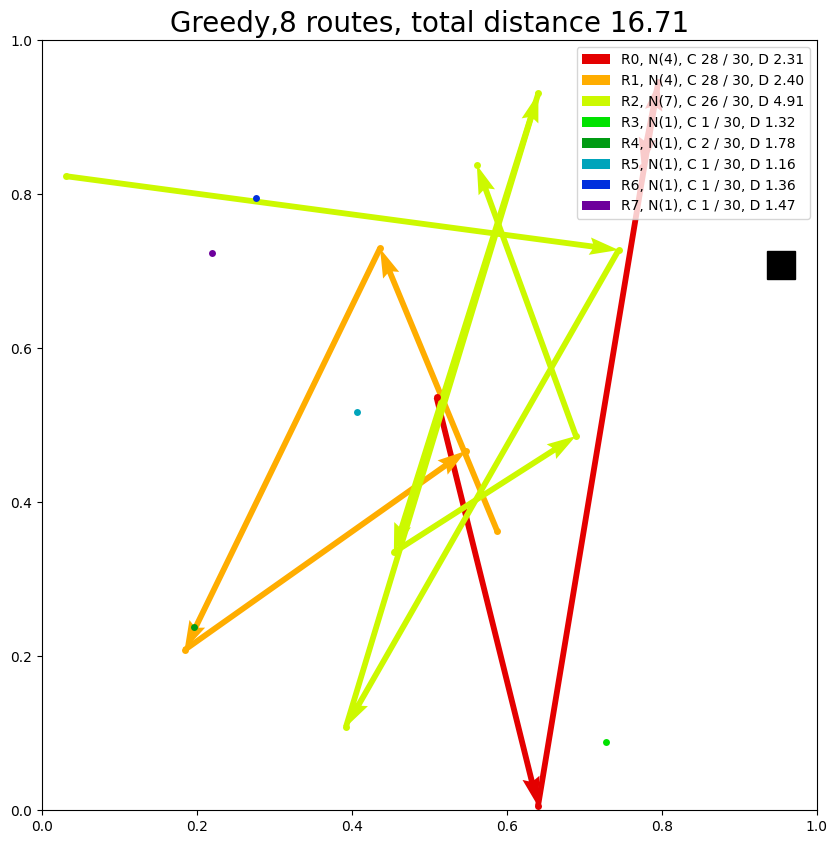

In [ ]:
import os
import numpy as np
import torch


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_nodes = 21

def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1,Greedy, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):

    plt.rc('font', family='Times New Roman', size=10)

    routes = [r[r != 0] for r in np.split(route.cpu().numpy(), np.where(route.cpu().numpy() == 0)[0]) if (r != 0).any()]
    depot = data.x[0].cpu().numpy()
    locs = data.x[1:].cpu().numpy()
    demands = data.demand.cpu().numpy()*10
    demands=demands[1:]

    capacity = data.capcity*10

    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize * 4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order

        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        #assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)

        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)

            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))

            x_prev, y_prev = x, y
            cum_demand += d

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, N({}), C {} / {}, D {:.2f}'.format(
                veh_number,
                len(r),
                int(total_route_demand) if round_demand else total_route_demand,
                int(capacity) if round_demand else capacity,
                dist
            )
        )

        qvs.append(qv)
    if Greedy:
        ax1.set_title('Greedy,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)
    else:
        ax1.set_title('Sampling1280,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)

    ax1.legend(handles=qvs)
    plt.legend(loc=1)
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')

    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)
    plt.show()
    #plt.savefig("./temp{}.png".format(54), dpi=600, bbox_inches='tight')

def vrp_matplotlib(Greedy=True):

    node_ = np.loadtxt('./vrp20_test_data.csv', dtype=float, delimiter=',')
    demand_=np.loadtxt('./vrp20_demand.csv', dtype=float, delimiter=',')
    capcity_=np.loadtxt('./vrp20_capcity.csv', dtype=float, delimiter=',')
    node_,demand_=node_.reshape(-1,n_nodes,2),demand_.reshape(-1,n_nodes)
    data_size = node_.shape[0]

    x=np.random.randint(1,data_size)
    # Calculate the distance matrix
    edges = np.zeros((n_nodes, n_nodes, 1))
    def c_dist(x1, x2):
        return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
    for i, (x1, y1) in enumerate(node_[x]):
        for j, (x2, y2) in enumerate(node_[x]):
            d = c_dist((x1, y1), (x2, y2))
            edges[i][j][0] = d
    edges_ = edges.reshape(-1, 1)

    edges_index = []
    for i in range(n_nodes):
        for j in range(n_nodes):
            edges_index.append([i, j])
    edges_index = torch.LongTensor(edges_index)
    edges_index = edges_index.transpose(dim0=0, dim1=1)

    datas = []
    data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index, edge_attr=torch.from_numpy(edges_).float(),
                demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
    datas.append(data)

    data_loder = DataLoader(datas, batch_size=1)



    agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
    agent.to(device)
    folder = 'trained'
    filepath = os.path.join(folder, '%s' % n_nodes)

    if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
    if Greedy:
        batch = next(iter(data_loder))
        batch.to(device)
        agent.eval()
        #-------------------------------------------------------------------------------------------Greedy
        with torch.no_grad():
            tour, _ = agent(batch, n_nodes * 2,True)
            #cost = reward1(batch.x, tour.detach(), n_nodes)
            #print(cost)
            #print(tour)
    #-------------------------------------------------------------------------------------------sampling1280
    else:
        datas_ = []
        batch_size1 = 128  # sampling batch_size
        for y in range(1280):
            data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index,
                        edge_attr=torch.from_numpy(edges_).float(),
                        demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                        capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
            datas_.append(data)
        dl = DataLoader(datas_, batch_size=batch_size1)

        min_tour=[]
        min_cost=100
        T=1.2#Temperature hyperparameters
        for batch in dl:
            with torch.no_grad():
                batch.to(device)
                tour1, _ = agent(batch, n_nodes * 2,False, T)
                cost = reward1(batch.x, tour1.detach(), n_nodes)

                id = np.array(cost.cpu()).argmin()
                m_cost=np.array(cost.cpu()).min()
                tour1=tour1.reshape(batch_size1,-1)
                if m_cost<min_cost:
                    min_cost=m_cost
                    min_tour=tour1[id]

        tour=min_tour.unsqueeze(-2)

    #--------------------------------------------------------------------------------------------
    for i, (data, tour) in enumerate(zip(data_loder, tour)):
        if Greedy:
            fig, ax = plt.subplots(figsize=(10, 10))
            plot_vehicle_routes(data, tour, ax,Greedy, visualize_demands=False, demand_scale=50, round_demand=True)
        else:
            fig, ax = plt.subplots(figsize=(10, 10))
            plot_vehicle_routes(data, tour, ax,Greedy, visualize_demands=False, demand_scale=50, round_demand=True)

#True:Greedy decoding / False:sampling1280
vrp_matplotlib(Greedy=True)